In [1]:
import os
import sys
import yaml
from glob import glob
from copy import deepcopy
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from corner import corner

from mejiro.analysis import lensing
from mejiro.utils import util

# read configuration file
import mejiro
# config_file = os.path.join(os.path.dirname(mejiro.__file__), 'data', 'mejiro_config', 'roman_data_challenge_mini.yaml')
config_file = '/grad/bwedig/mejiro/mejiro/data/mejiro_config/hwo.yaml'
with open(config_file, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

if config['dev']:
    config['pipeline_label'] += '_dev'

In [2]:
data_dir = os.path.join(config['data_dir'], config['pipeline_label'], '05')

# pickles = sorted(glob(os.path.join(data_dir, 'sca*', 'Exposure_*.pkl')))
pickles = sorted(glob(os.path.join(data_dir, 'Exposure_*.pkl')))
print(f'Found {len(pickles)} pickle(s) in {data_dir}')

Found 370 pickle(s) in /data/bwedig/mejiro/hwo_dev/05


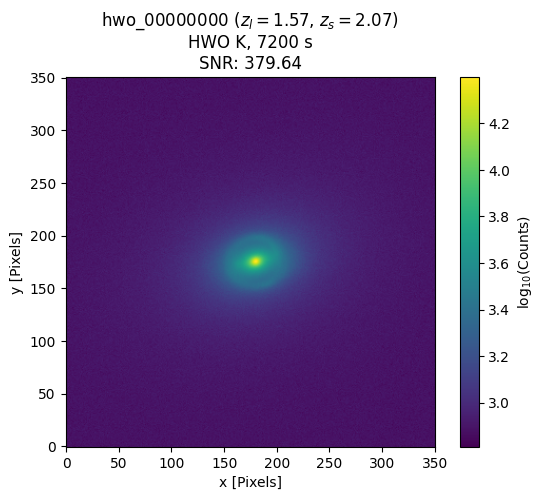

In [3]:
sample = util.unpickle(pickles[0])
sample.plot(show_snr=True)

In [4]:
from mejiro.analysis.snr_calculation import get_snr

snr, masked_snr_array = get_snr(sample, verbose=True)

Using structure
[[0 1 0]
 [1 1 1]
 [0 1 0]]
Identified 1 region(s)
Region 1: SNR = 379.6359966473038


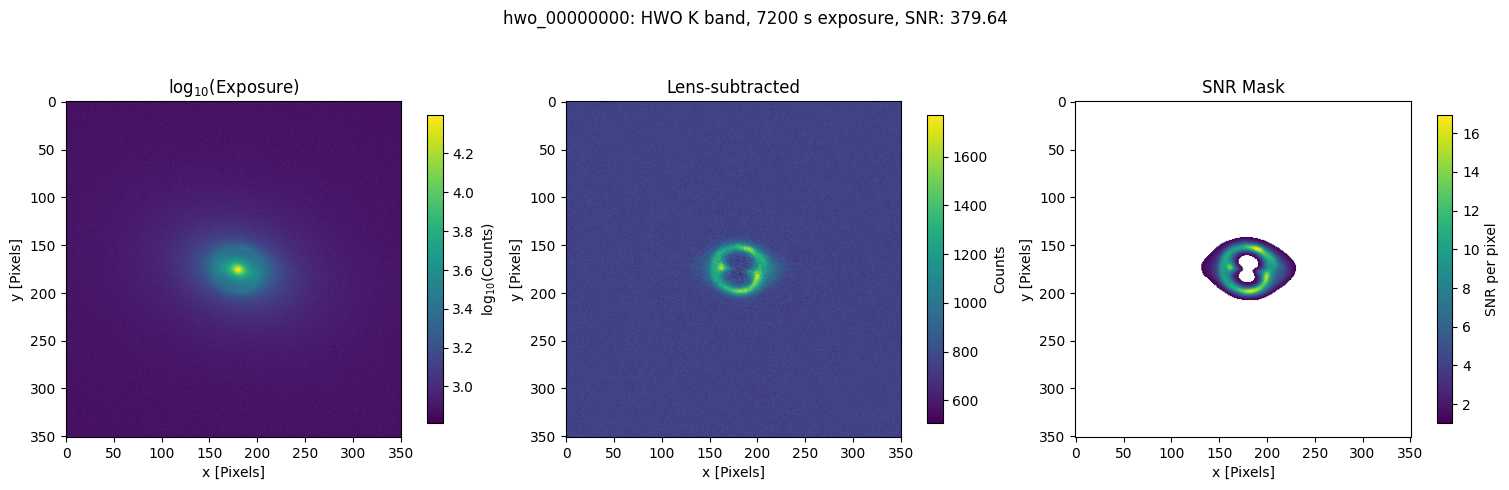

In [5]:
show_snr = True

_, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
im0 = ax[0].imshow(np.log10(sample.exposure))
im1 = ax[1].imshow(sample.exposure - sample.lens_exposure)
im2 = ax[2].imshow(masked_snr_array)

cbar0 = plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
cbar0.set_label(r'log$_{10}$(Counts)')

cbar1 = plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
cbar1.set_label(r'Counts')

cbar2 = plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)
cbar2.set_label(r'SNR per pixel')

ax[0].set_title(r'log$_{10}$(Exposure)')
ax[1].set_title('Lens-subtracted')
ax[2].set_title('SNR Mask')

for a in ax:
    a.set_xlabel('x [Pixels]')
    a.set_ylabel('y [Pixels]')

title = f'{sample.synthetic_image.strong_lens.name}: {sample.synthetic_image.instrument_name} {sample.synthetic_image.band} band, {sample.exposure_time} s exposure'
if show_snr:
    snr = sample.get_snr()
    title += f', SNR: {snr:.2f}'
plt.suptitle(title)

plt.show()

Note: if you decide to save the following figure, make sure to save it with a high DPI otherwise you can get weird boxes around bright sources which must be some kind of compression artifact.

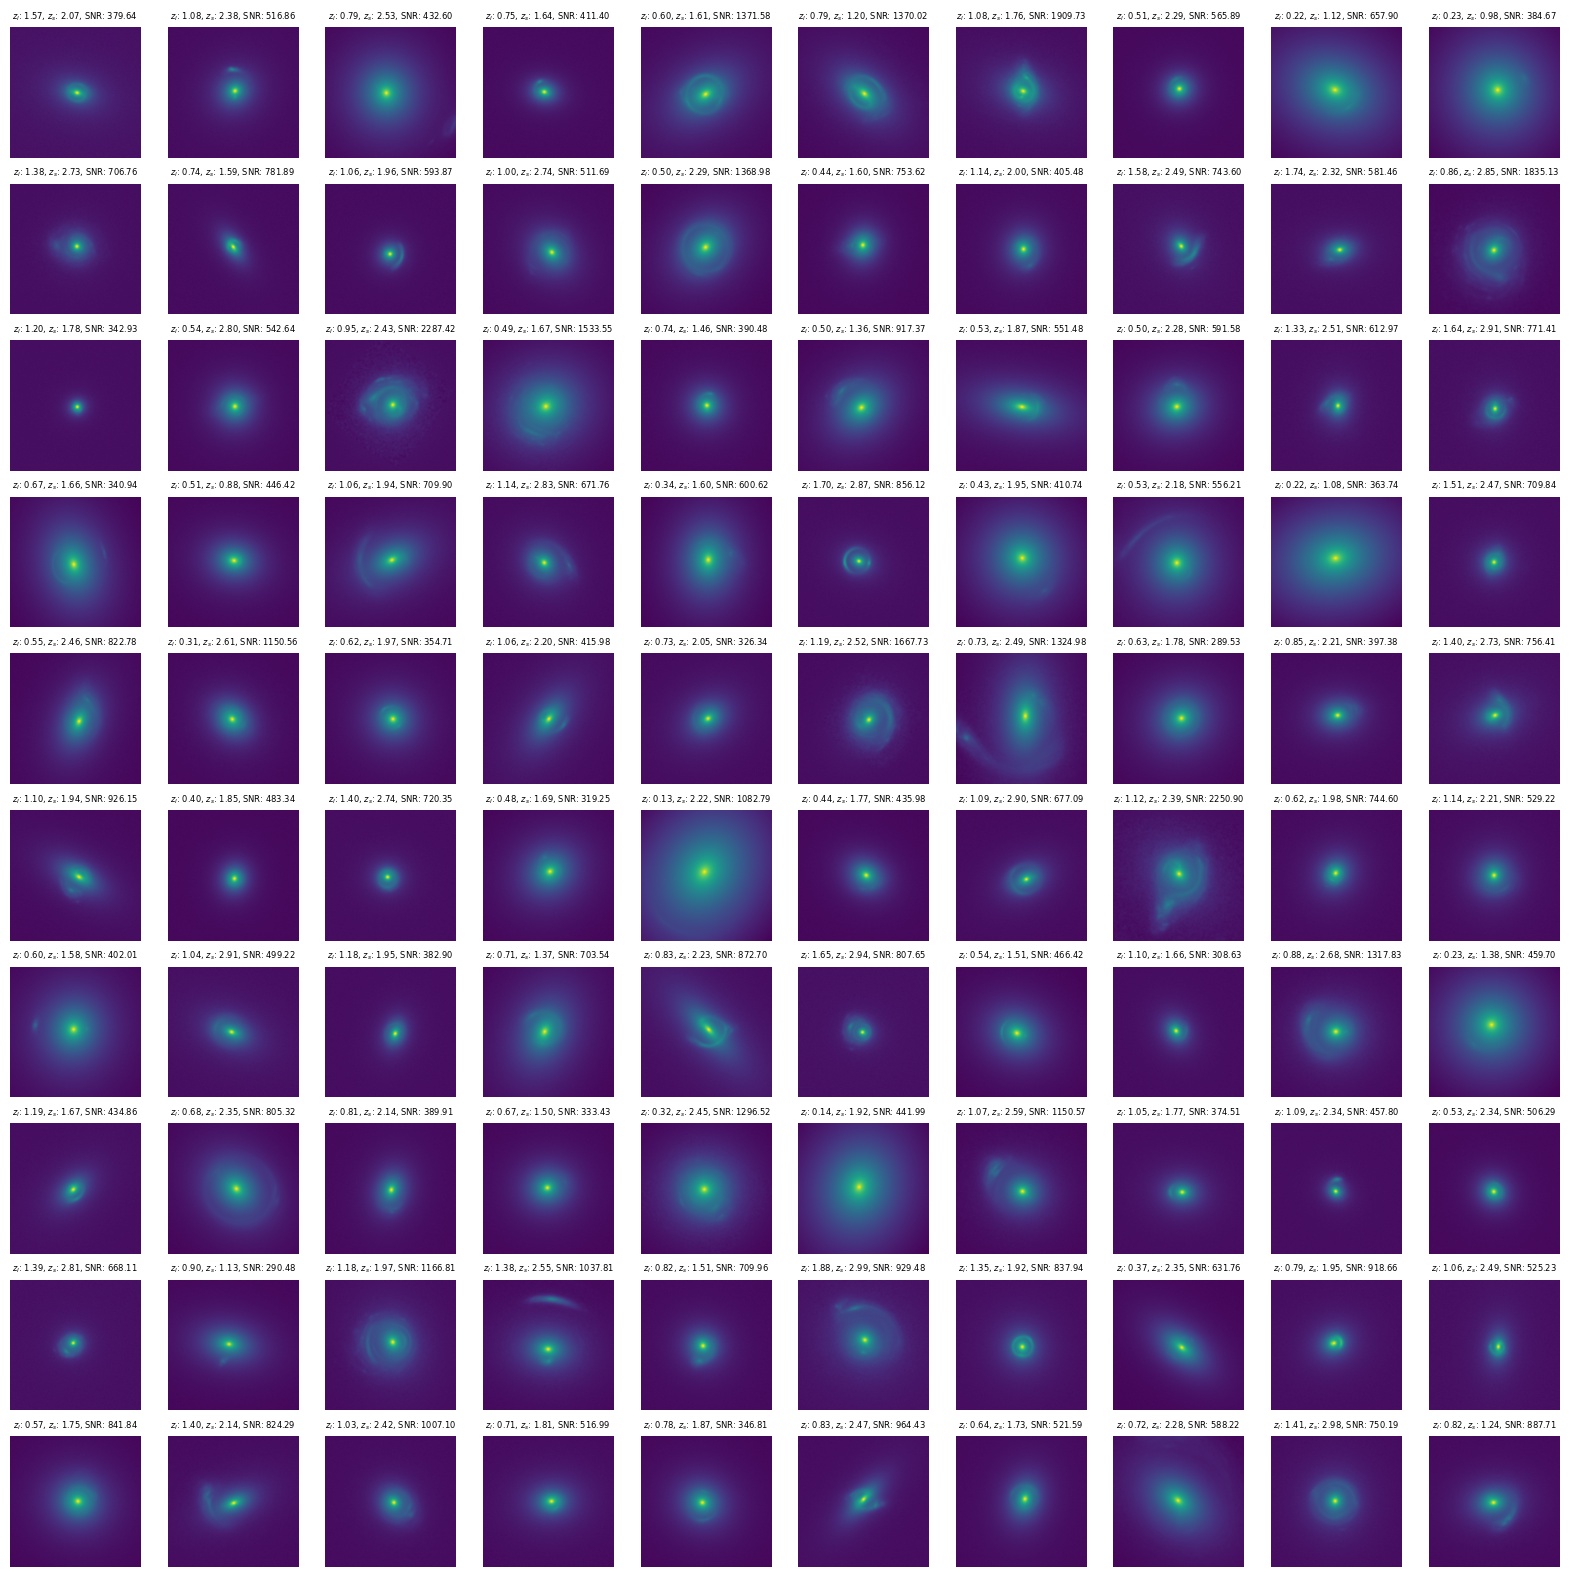

In [6]:
_, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(100):
    sample = util.unpickle(pickles[i])
    snr = sample.get_snr()

    ax.flat[i].imshow(np.log10(sample.exposure))
    ax.flat[i].axis('off')
    ax.flat[i].set_title(f'$z_l$: {sample.synthetic_image.strong_lens.z_lens:.2f}, $z_s$: {sample.synthetic_image.strong_lens.z_source:.2f}, SNR: {snr:.2f}', fontsize=6)

# plt.savefig('exposures_grid.png', dpi=600)
plt.show()

Found 0 exposures with all target bands: ['I', 'J', 'K']


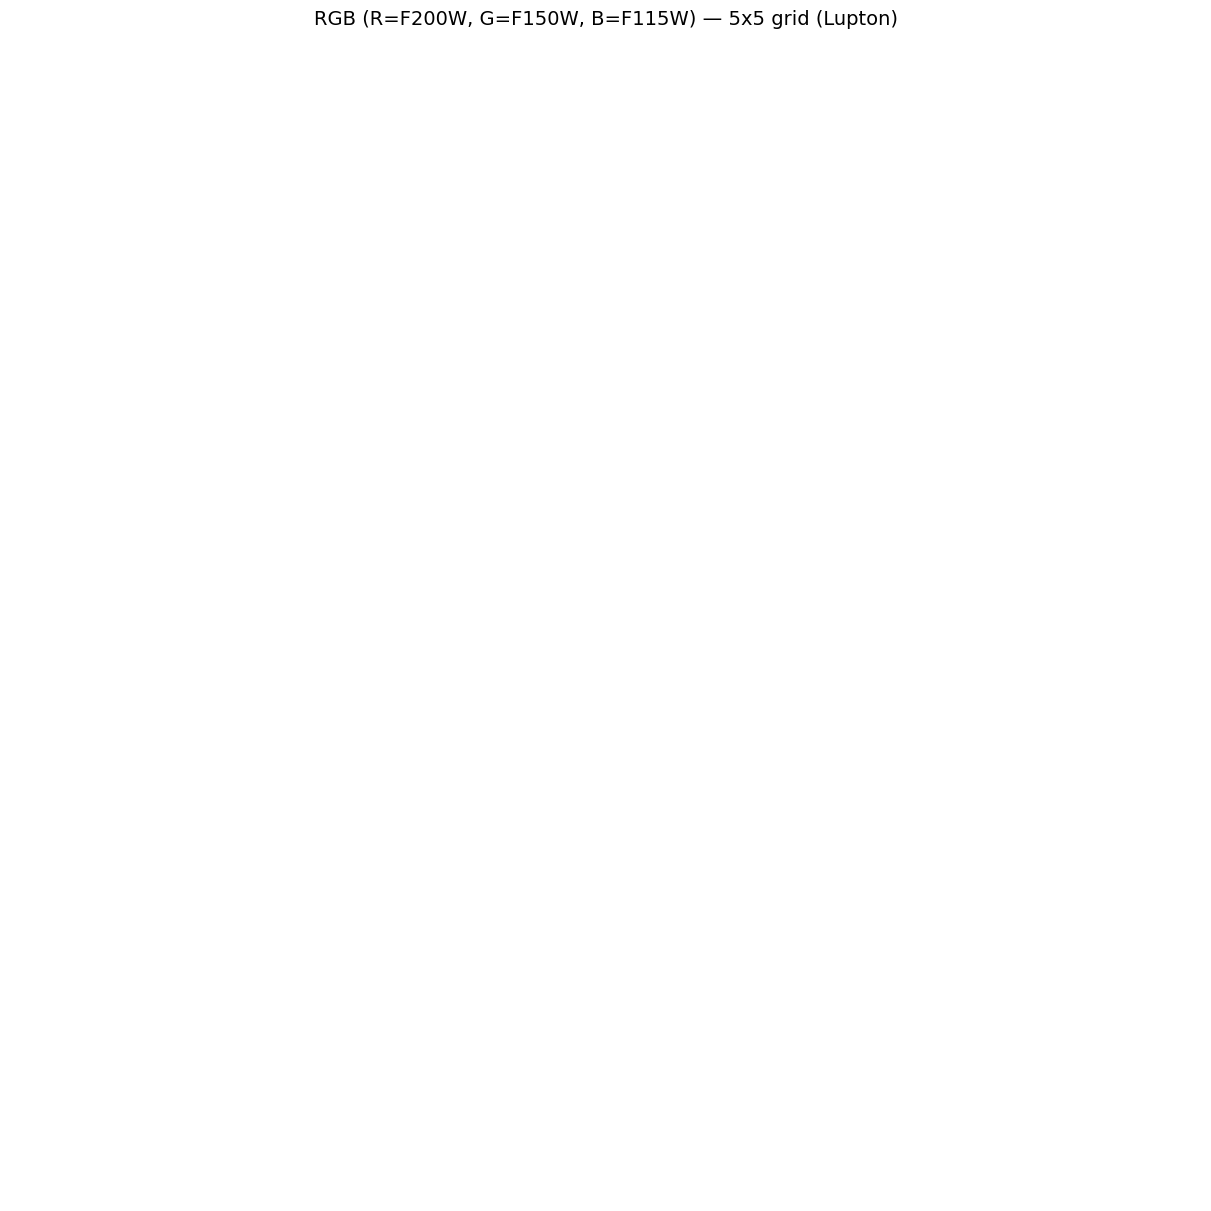

In [ ]:
from astropy.visualization import make_lupton_rgb

from collections import defaultdict

# target bands mapped to RGB channels (R, G, B)
target_bands = ['F200W', 'F150W', 'F115W']
# target_bands = ['I', 'J', 'K']

# group pickle files by exposure id
by_id = defaultdict(dict)
for p in pickles:
    bn = os.path.basename(p)
    parts = bn.replace('.pkl', '').split('_')
    if len(parts) < 4:
        continue
    exp_id = parts[2]
    band = parts[3]
    by_id[exp_id][band] = p

# collect ids that have all target bands
good_ids = [eid for eid, bands in by_id.items() if all(b in bands for b in target_bands)]
print(f'Found {len(good_ids)} exposures with all target bands: {target_bands}')

# limit to 25 images for 5x5 grid
n = 25
good_ids = good_ids[:n]

fig, axes = plt.subplots(5, 5, figsize=(12, 12), constrained_layout=True)

for ax_idx, eid in enumerate(good_ids):
    row = ax_idx // 5
    col = ax_idx % 5
    axc = axes[row, col]

    try:
        # load exposures for each band in R,G,B order
        samples = [util.unpickle(by_id[eid][b]) for b in target_bands]
        channels = [np.array(s.exposure, dtype=float) for s in samples]

        clean = []
        for ch in channels:
            ch = np.array(ch, dtype=float)
            rng = ch.max() - ch.min()
            if rng > 0:
                clean.append(255 * (ch - ch.min()) / rng)
            else:
                clean.append(np.zeros_like(ch, dtype=float))

        rgb = make_lupton_rgb(image_r=clean[0], image_g=clean[1], image_b=clean[2], minimum=np.min(clean), stretch=2, Q=8)

        # normalize final rgb to uint8 [0,255]
        if np.issubdtype(rgb.dtype, np.floating):
            rgb = (np.clip(rgb, 0.0, 1.0) * 255).astype(np.uint8)
        else:
            rgb = np.clip(rgb, 0, 255).astype(np.uint8)

        axc.imshow(rgb, origin='lower', interpolation='nearest')
        axc.axis('off')

        # title with id and SNR from one of the samples
        snr_val = samples[0].get_snr()
        axc.set_title(f'{eid}, SNR: {snr_val:.1f}', fontsize=8)
    except Exception as e:
        axc.text(0.5, 0.5, 'error', ha='center', va='center')
        axc.axis('off')

# turn off any unused axes if fewer than 25
for i in range(len(good_ids), 25):
    axes.flat[i].axis('off')

plt.suptitle('RGB (R=F200W, G=F150W, B=F115W) — 5x5 grid (Lupton)', fontsize=14)
plt.show()